In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
import numpy as np
from mpmath import polylog
from sklearn.model_selection import train_test_split
import scipy.integrate
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import math
import random
from sklearn.model_selection import train_test_split
import time
import itertools
from sklearn.preprocessing import MinMaxScaler
from sympy import Float


class MLP(nn.Module):
    """
        Class defining neural network approximator for the integrand.
    """

    def __init__(self, input_size, hidden_size):
        """
            Main constructor.

            :param input_size: input layer size (number of integrand dimensions)
            :param hidden_size: hidden layer size (arbitrary value, which would be chosen when training the network)
        """
        super(MLP, self).__init__()
        self.input_size = input_size
        self.input_hidden_layer = nn.Linear(input_size, hidden_size)  # initialisation of input->hidden layers structure
        self.sigmoid_activation = nn.Sigmoid()  # hidden layer activation function
        self.output_layer = nn.Linear(hidden_size, 1)  # output layer initialisation (always size 1)

    def forward(self, x):
        """
            Forward propagation of the data through the network.

            :param x:    the data to be propagated

            :returns: data after the forward propagation
        """
        x = self.input_hidden_layer(x)  # input->hidden propagation
        x = self.sigmoid_activation(x)  # sigmoid activation function applied
        x = self.output_layer(x)  # hidden->output propagation

        return x


def train(model, criterion, optimizer, x_train, y_train, epochs, verbose=True):
    """
        Trains the model.

        :param model:      The model to be trained
        :param criterion:  Loss function
        :param optimizer:  Optimization algorithm
        :param x_train:    Training inputs
        :param y_train:    True labels
        :param epochs:     Number of training epochs
        :param verbose:    Boolean depicting whether should the network print each 100 epochs done message,
                           or only the completion message.

        :returns: loss functions history
    """
    loss_history = []
    start_time = time.time()
    for epoch in range(epochs):
        predictions = model(x_train)  # forward propagation of all the data
        loss = criterion(predictions, y_train)  # loss function calculation

        optimizer.zero_grad()  # gradients are being reset
        loss.backward()  # backwards data propagation
        optimizer.step()  # optimization step (network params are being updated)

        loss_history.append(loss.item())  # current loss function added to history

        # hereon the logs are being printed
        if verbose:
            if (epoch + 1) % 100 == 0:
                print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.10f}')
    total_time = time.time() - start_time
    print(f'Training done! Time elapsed: {total_time:.2f} seconds')

    return loss_history  # loss history is returned


def test(model, criterion, x_test, y_test):
    """
        Tests the model.

        :param model:     The trained model
        :param criterion: Loss function
        :param x_test:    Test inputs
        :param y_test:    True labels

        :returns: test loss function value
    """
    with torch.no_grad():  # no gradients will be calculated
        predictions = model(x_test)  # forward data propagation
        loss = criterion(predictions, y_test)  # loss function for the test data

    return loss.item()  # loss function value (item() required to convert tensor to scalar)


def predict_with(model, x_test):
    """
        Uses the model to predict values based on x_test arguments.

        :param model:  the trained model
        :param x_test: test inputs

        :returns: predicted function value
    """
    with torch.no_grad():
        prediction = model(x_test)  # forward data propagation

    return prediction


def extract_params(model):
    """
        Extracts weights and biases from the network.

        :param model: the trained model

        :returns: tuple of 4 numpy.ndarray-s with biases1, weights1, biases2 and weights2
                  (number represents 1 - input->hidden layers params, 2 - hidden->output layers params)
    """

    b1 = model.input_hidden_layer.bias.detach().numpy()
    w1 = model.input_hidden_layer.weight.detach().numpy()
    b2 = model.output_layer.bias.detach().numpy()
    w2 = model.output_layer.weight.detach().numpy().flatten()

    return b1, w1, b2, w2


class NeuralNumericalIntegration:

    @staticmethod
    def calculate(alphas, betas, network_params, n_dims=1):
        """
            Calculates integrand value using neural network model params
            across given boundaries.

            :param alphas:         lower boundaries sequence (should be placed in integration order)
            :param betas:          upper boundaries sequence (should be placed in integration order)
            :param network_params: params for the trained neural network
            :param n_dims:          number of integrand dimensions (default value is 1)

            :returns: integrand value
        """

        b1, w1, b2, w2 = network_params

        def Phi_j(b1_j_, w1_j_):
            def xi(r_):
                prod_ = 1
                for d in range(1, n_dims + 1):
                    prod_ *= (-1) ** (r_ / (2 ** (n_dims - d)))

                return prod_

            def l(i_, r_):
                if (r_ / (2 ** (n_dims - (i_ + 1)))) % 2 == 0:
                    return alphas[i_]
                else:
                    return betas[i_]

            Phi_sum = 0

            for r in range(1, (2 ** n_dims) + 1):
                sum_ = 0
                for i in range(n_dims):
                    sum_ += w1_j_[i] * l(i, r)
                Phi_sum += xi(r) * polylog(n_dims, -np.exp(-b1_j_ - sum_))

            return Phi_sum

        integral_sum = 0

        prod_bound = 1
        for i in range(n_dims):
            prod_bound *= betas[i] - alphas[i]

        for w2_j, w1_j, b1_j in zip(w2, w1, b1):

            Phi_j_ = Phi_j(b1_j, w1_j)
            prod_w = 1
            for i in range(n_dims):
                prod_w *= w1_j[i]

            integral_sum += w2_j * (prod_bound + Phi_j_ / prod_w)

        
        result = b2 * prod_bound + integral_sum

        return result


    @staticmethod
    def calculate2(alphas, betas, network_params, n_dims=1):
        alpha1, alpha2, beta1, beta2 = alphas[0], alphas[1], betas[0], betas[1]
        b1, w1, b2, w2 = network_params
        def Phi_j(alpha1, beta1, alpha2, beta2, b1_j, w1_1j, w1_2j):

            term_1 = polylog(2, -np.exp(-b1_j - w1_1j * alpha1 - w1_2j * alpha2))
            term_2 = polylog(2, -np.exp(-b1_j - w1_1j * alpha1 - w1_2j * beta2))
            term_3 = polylog(2, -np.exp(-b1_j - w1_1j * beta1 - w1_2j * alpha2))
            term_4 = polylog(2, -np.exp(-b1_j - w1_1j * beta1 - w1_2j * beta2))
            
            return term_1 - term_2 - term_3 + term_4
   
        integral_sum = 0 
            
        for w2_j, w1_1j, w1_2j, b1_j in zip(w2, w1[:, 0], w1[:, 1], b1):
            phi_j = Phi_j(alpha1, beta1, alpha2, beta2, b1_j, w1_1j, w1_2j) 
            summ = w2_j * ((beta1 - alpha1) * (beta2 - alpha2) + phi_j / (w1_1j * w1_2j))
            integral_sum += summ
        
        return b2 * (beta1 - alpha1) * (beta2 - alpha2) + integral_sum 
    
    @staticmethod
    def integrate(model, alphas, betas, n_dims=1):
        """
            Integrates function-approximator (model) of n-dim dimensions over given boundaries.

            :param model: the trained model-approximator
            :param alphas: lower boundaries sequence (should be placed in integration order)
            :param betas:  upper boundaries sequence (should be placed in integration order)
            :param n_dims: number of integrand dimensions (default value is 1)

            :returns: neural numeric integration result
        """
        network_params = extract_params(model)

        return NeuralNumericalIntegration.calculate2(alphas, betas, network_params, n_dims)


def generate_data(func, lower, upper, n_samples=100, n_dim=1):
    """
        Generates data in the form of a 2D tensor of variables for the function and neural network input
        as well as the function values for the generated tensor of variables.

        :param func:     function to provide values for the variables
        :param lower:    lower bounds of variable values
        :param upper:    upper bounds of variable values
        :param n_samples: number of points of data to generate per dimension (default value is 100)
        :param n_dim:     number of dimensions of the function func (default value is 1)

        :returns: dataset of variables X and function values y
    """
    X, y = None, None
    if n_dim == 1:
        X = torch.linspace(lower[0], upper[0], n_samples).view(n_samples, 1)
        y = func(X).view(n_samples, 1)
    else:
        ranges = [torch.linspace(lower[n], upper[n], n_samples).tolist() for n in range(n_dim)]
        combinations = list(itertools.product(*ranges))
        X = torch.tensor(combinations, dtype=torch.float32)
        y = func(X).view(-1, 1)

    return X, y


def scale_data(
    X_init: torch.Tensor, 
    y_init: torch.Tensor, 
    frange: tuple[int, int]=(0, 1), 
    n_dim: int=1
) -> tuple[torch.Tensor, torch.Tensor]:
    """
        Scales function dataset to the specific range frange.

        :param X_init: initial variables
        :param y_init: initial function values
        :param frange: range of scaled values (default is [0, 1])
        :param n_dim:  number of function dimensions (default is 1)

        :returns: tuple of scaled X-s and y-s to range frange.
    """
    if not isinstance(X_init, torch.Tensor) or not isinstance(y_init, torch.Tensor):
        raise TypeError("Input X_init and y_init must be torch tensors.")

    if X_init.ndim != 2:
        raise ValueError("X_init must be a 2D tensor (m, n_dim).")

    if y_init.ndim != 2 or y_init.shape[1] != 1:
        raise ValueError("y_init must be a 2D tensor (m, 1).")

    if X_init.shape[0] != y_init.shape[0]:
        raise ValueError("X_init and y_init must have the same number of rows (m).")

    min_val_x = torch.min(X_init, dim=0).values
    max_val_x = torch.max(X_init, dim=0).values
    min_val_y = torch.min(y_init)
    max_val_y = torch.max(y_init)

    scaled_X = (frange[1] - frange[0]) * (X_init - min_val_x) / (max_val_x - min_val_x) + frange[0]
    scaled_y = (frange[1] - frange[0]) * (y_init - min_val_y) / (max_val_y - min_val_y) + frange[0]

    return scaled_X, scaled_y


def descale_result(
    nni_scaled: float, 
    X_init: torch.Tensor, 
    y_init: torch.Tensor,     
    frange: tuple[int, int]=(0, 1), 
    n_dim: int=1
) -> float:
    """
        Restores true value to the scaled integral.

        :param nni_scaled: scaled integral value
        :param X_init:     initial variables
        :param y_init:     initial function values
        :param frange:     range of scaled values (default is [0, 1])
        :param n_dim:      number of function dimensions (default is 1)

        :returns: descaled integral value.
    """
    if not isinstance(X_init, torch.Tensor) or not isinstance(y_init, torch.Tensor):
        raise TypeError("Inputs must be torch tensors.")

    if X_init.ndim != 2:
        raise ValueError("X_init must be a 2D tensor.")

    if y_init.ndim != 1 and y_init.ndim != 2 :
        raise ValueError("y_init must be a 2D tensor with shape (num_of_points,1).")

    if y_init.ndim == 2 and y_init.shape[1] !=1:
      raise ValueError("y_init must be a 2D tensor with shape (num_of_points,1).")

    xmin = torch.min(X_init, dim=0).values
    xmax = torch.max(X_init, dim=0).values
    fmin = torch.min(y_init)
    fmax = torch.max(y_init)
    frange_size = frange[1] - frange[0]
    VS = torch.prod(xmax - xmin)
    VSS = (frange_size) ** n_dim

    return nni_scaled * (VS * (fmax - fmin) / (VSS * (frange_size))) + (fmin - (fmax - fmin) / (frange_size) * frange[0]) * VS


# Hyperparams

In [3]:
input_size = 1
hidden_size = 100
learning_rate = 0.001
num_epochs = 5000

a = [0.0]
b = [1.0]

# Oscillatory 1D: Example

In [3]:
u = 1
c = 1

In [4]:
def osc_1d(X):
    return torch.cos(2 * math.pi * u + X * c)

def osc_1d_float(X):
    return math.cos(2 * math.pi * u + X * c)

In [5]:
X, y = generate_data(osc_1d, lower=a, upper=b, n_samples=10000, n_dim=1)

In [6]:
x_np = X[:, 0].numpy()
y_np = y.numpy()
plt.plot(x_np, y_np)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Oscillatory 1D')
plt.grid(True)
plt.show()

In [7]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

## Model

### Hyperparams for the NN model

In [8]:
input_size = 1
hidden_size = 10
learning_rate = 0.001
num_epochs = 5000

### Model definition, compilation and training

In [9]:
model = MLP(input_size, hidden_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
train_history = train(model, criterion, optimizer, x_train, y_train, num_epochs)

Epoch [100/5000], Loss: 0.1102508828
Epoch [200/5000], Loss: 0.0258985069
Epoch [300/5000], Loss: 0.0210698824
Epoch [400/5000], Loss: 0.0196088664
Epoch [500/5000], Loss: 0.0180826373
Epoch [600/5000], Loss: 0.0164967645
Epoch [700/5000], Loss: 0.0148867508
Epoch [800/5000], Loss: 0.0132828793
Epoch [900/5000], Loss: 0.0117122121
Epoch [1000/5000], Loss: 0.0101998644
Epoch [1100/5000], Loss: 0.0087695224
Epoch [1200/5000], Loss: 0.0074432152
Epoch [1300/5000], Loss: 0.0062404233
Epoch [1400/5000], Loss: 0.0051767072
Epoch [1500/5000], Loss: 0.0042621731
Epoch [1600/5000], Loss: 0.0035001701
Epoch [1700/5000], Loss: 0.0028866765
Epoch [1800/5000], Loss: 0.0024106349
Epoch [1900/5000], Loss: 0.0020553051
Epoch [2000/5000], Loss: 0.0018004203
Epoch [2100/5000], Loss: 0.0016246279
Epoch [2200/5000], Loss: 0.0015077365
Epoch [2300/5000], Loss: 0.0014323054
Epoch [2400/5000], Loss: 0.0013844619
Epoch [2500/5000], Loss: 0.0013539616
Epoch [2600/5000], Loss: 0.0013337481
Epoch [2700/5000], Lo

In [10]:
summary(model, (input_size,)) # (input_size, ) - input shape

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 10]              20
           Sigmoid-2                   [-1, 10]               0
            Linear-3                    [-1, 1]              11
Total params: 31
Trainable params: 31
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


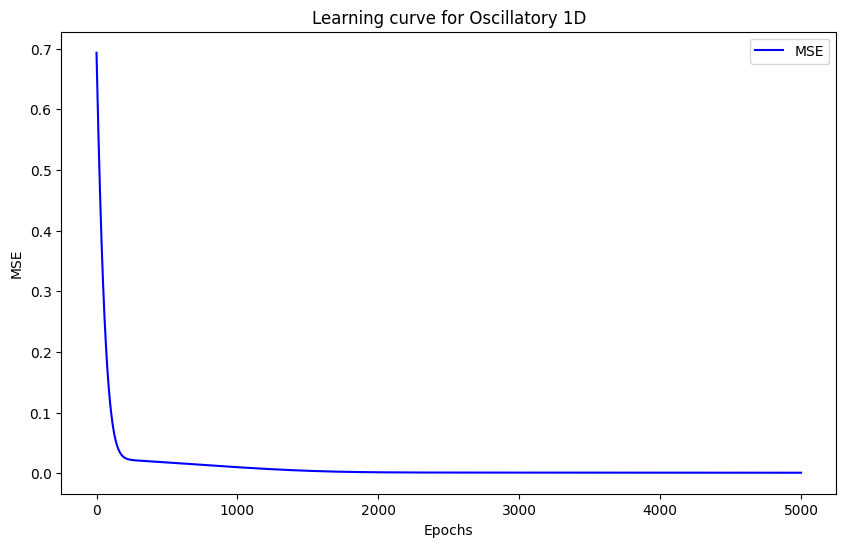

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(train_history, label='MSE', color='b')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.title('Learning curve for Oscillatory 1D')
plt.legend()
plt.grid(False)
plt.show()

### Model testing

In [12]:
test_loss = test(model, criterion, x_test, y_test)
print(f"Test Loss: {test_loss:.10f}")

Test Loss: 0.0010378731


In [13]:
nni = NeuralNumericalIntegration.integrate(model, a, b, n_dims=1)
nni

IndexError: list index out of range

In [ ]:
result, error = scipy.integrate.quad(osc_1d_float, a[0], b[0])

print("Integral:", result)
print("Error:", error)

In [ ]:
abs(nni - result)

In [ ]:
def scale_data(
    X_init: torch.Tensor, 
    y_init: torch.Tensor, 
    frange: tuple[int, int]=(0, 1), 
    n_dim: int=1
) -> tuple[torch.Tensor, torch.Tensor]:
    """
        Scales function dataset to the specific range frange.

        :param X_init: initial variables
        :param y_init: initial function values
        :param frange: range of scaled values (default is [0, 1])
        :param n_dim:  number of function dimensions (default is 1)

        :returns: tuple of scaled X-s and y-s to range frange.
    """
    if not isinstance(X_init, torch.Tensor) or not isinstance(y_init, torch.Tensor):
        raise TypeError("Input X_init and y_init must be torch tensors.")

    if X_init.ndim != 2:
        raise ValueError("X_init must be a 2D tensor (m, n_dim).")

    if y_init.ndim != 2 or y_init.shape[1] != 1:
        raise ValueError("y_init must be a 2D tensor (m, 1).")

    if X_init.shape[0] != y_init.shape[0]:
        raise ValueError("X_init and y_init must have the same number of rows (m).")

    min_val_x = torch.min(X_init, dim=0).values
    max_val_x = torch.max(X_init, dim=0).values
    min_val_y = torch.min(y_init)
    max_val_y = torch.max(y_init)

    scaled_X = (frange[1] - frange[0]) * (X_init - min_val_x) / (max_val_x - min_val_x) + frange[0]
    scaled_y = (frange[1] - frange[0]) * (y_init - min_val_y) / (max_val_y - min_val_y) + frange[0]

    return scaled_X, scaled_y


def descale_result(
    nni_scaled: float, 
    X_init: torch.Tensor, 
    y_init: torch.Tensor,     
    frange: tuple[int, int]=(0, 1), 
    n_dim: int=1
) -> float:
    """
        Restores true value to the scaled integral.

        :param nni_scaled: scaled integral value
        :param X_init:     initial variables
        :param y_init:     initial function values
        :param frange:     range of scaled values (default is [0, 1])
        :param n_dim:      number of function dimensions (default is 1)

        :returns: descaled integral value.
    """
    if not isinstance(X_init, torch.Tensor) or not isinstance(y_init, torch.Tensor):
        raise TypeError("Inputs must be torch tensors.")

    if X_init.ndim != 2:
        raise ValueError("X_init must be a 2D tensor.")

    if y_init.ndim != 1 and y_init.ndim != 2 :
        raise ValueError("y_init must be a 2D tensor with shape (num_of_points,1).")

    if y_init.ndim == 2 and y_init.shape[1] !=1:
      raise ValueError("y_init must be a 2D tensor with shape (num_of_points,1).")

    xmin = torch.min(X_init, dim=0).values
    xmax = torch.max(X_init, dim=0).values
    fmin = torch.min(y_init)
    fmax = torch.max(y_init)
    frange_size = frange[1] - frange[0]
    VS = torch.prod(xmax - xmin)
    VSS = (frange_size) ** n_dim

    return nni_scaled * (VS * (fmax - fmin) / (VSS * (frange_size))) + (fmin - (fmax - fmin) / (frange_size) * frange[0]) * VS

In [ ]:
X_init, y_init = [], []
X_i, X_i2 = [], []

for i in range(10):
    X_i.append(i)
    X_i2.append(i * 2)
    y_init.append(i*i)
X_init.append(X_i)
X_init.append(X_i2)

X_init, y_init = torch.transpose(torch.tensor(X_init), 0, 1), torch.tensor(y_init).unsqueeze(1)

X_init.shape, y_init.shape

In [ ]:
X, y = scale_data(X_init, y_init, n_dim=1)
X, y

In [ ]:
x_np = X_init[:, 0]
y_np = y_init
plt.plot(x_np, y_np)
plt.xlabel('x')
plt.ylabel('y')
plt.title("Oscillatory 1D")
plt.grid(True)
plt.show()

In [ ]:
x_np = X[:, 0].numpy()
y_np = y.numpy()
plt.plot(x_np, y_np)
plt.xlabel('x')
plt.ylabel('y')
plt.title("Oscillatory 1D")
plt.grid(True)
plt.show()

# Simple function test

## 1D case

In [14]:
def par(X):
    return X * X

In [15]:
a = [0.0]
b = [5.0]
aa = [0.0, 0,0]
bb = [5.0, 5.0]
a_ = [0.0]
b_ = [1.0]

In [16]:
X_init, y_init = generate_data(par, lower=a, upper=b, n_samples=10000, n_dim=1)
X_init.shape, y_init.shape

(torch.Size([10000, 1]), torch.Size([10000, 1]))

In [17]:
x_np = X_init.numpy()
y_np = y_init.numpy()
plt.plot(x_np, y_np)
plt.xlabel('x')
plt.ylabel('y')
plt.title('f(x^2)')
plt.grid(True)
plt.show()

In [18]:
X, y = scale_data(X_init, y_init, n_dim=1)
X.shape, y.shape

(torch.Size([10000, 1]), torch.Size([10000, 1]))

In [19]:
x_np = X[:, 0].numpy()
y_np = y.numpy()
plt.plot(x_np, y_np)
plt.xlabel('x')
plt.ylabel('y')
plt.title('f(x^2)')
plt.grid(True)
plt.show()

In [20]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

## Model

### Hyperparams for the NN model

In [21]:
input_size = 1
hidden_size = 100
learning_rate = 0.001
num_epochs = 5000

### Model definition, compilation and training

In [22]:
model = MLP(input_size, hidden_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
train_history = train(model, criterion, optimizer, x_train, y_train, num_epochs)

Epoch [100/5000], Loss: 0.0424284935
Epoch [200/5000], Loss: 0.0123116253
Epoch [300/5000], Loss: 0.0067321253
Epoch [400/5000], Loss: 0.0063717524
Epoch [500/5000], Loss: 0.0062906723
Epoch [600/5000], Loss: 0.0062081157
Epoch [700/5000], Loss: 0.0061205258
Epoch [800/5000], Loss: 0.0060284082
Epoch [900/5000], Loss: 0.0059319343
Epoch [1000/5000], Loss: 0.0058309757
Epoch [1100/5000], Loss: 0.0057250722
Epoch [1200/5000], Loss: 0.0056134388
Epoch [1300/5000], Loss: 0.0054949187
Epoch [1400/5000], Loss: 0.0053679445
Epoch [1500/5000], Loss: 0.0052304645
Epoch [1600/5000], Loss: 0.0050798706
Epoch [1700/5000], Loss: 0.0049129371
Epoch [1800/5000], Loss: 0.0047257910
Epoch [1900/5000], Loss: 0.0045139706
Epoch [2000/5000], Loss: 0.0042726458
Epoch [2100/5000], Loss: 0.0039970661
Epoch [2200/5000], Loss: 0.0036833568
Epoch [2300/5000], Loss: 0.0033296517
Epoch [2400/5000], Loss: 0.0029375367
Epoch [2500/5000], Loss: 0.0025136026
Epoch [2600/5000], Loss: 0.0020706642
Epoch [2700/5000], Lo

In [23]:
summary(model, (input_size,)) # (input_size, ) - input shape

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 100]             200
           Sigmoid-2                  [-1, 100]               0
            Linear-3                    [-1, 1]             101
Total params: 301
Trainable params: 301
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [24]:
plt.figure(figsize=(10, 6))
plt.plot(train_history, label='MSE', color='b')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.title('Learning curve for Oscillatory 1D')
plt.legend()
plt.grid(False)
plt.show()

### Model testing

In [25]:
test_loss = test(model, criterion, x_test, y_test)
print(f"Test Loss: {test_loss:.10f}")

Test Loss: 0.0000072306


In [26]:
nni_scaled = NeuralNumericalIntegration.integrate(model, a_, b_, n_dims=1)
nni = descale_result(nni_scaled, X_init, y_init, frange=(0, 1), n_dim=1)

IndexError: list index out of range

In [ ]:
result, error = scipy.integrate.quad(par, a[0], b[0])

print("Integral:", result)
print("Error:", error)

In [ ]:
abs(nni - result)

## 2D case

In [ ]:
def par2d(X):
    return X[:, 0] * X[:, 0] + X[:, 1] * X[:, 1]

def par2d_float(X):
    return X[0] * X[0] + X[1] * X[1]

In [ ]:
a = [0.0]
b = [5.0]
aa = [0.0, 0,0]
bb = [5.0, 5.0]
a_ = [0.0]
b_ = [1.0]
aa_ = [0.0, 0.0]
bb_ = [1.0, 1.0]

In [ ]:
X_init, y_init = generate_data(par2d, lower=aa, upper=bb, n_samples=100, n_dim=2)
X_init.shape, y_init.shape

In [ ]:
x1_coords = X_init[:, 0].numpy()
x2_coords = X_init[:, 1].numpy()
values = y_init.squeeze().numpy()
    
plt.figure(figsize=(8, 6))
plt.scatter(x1_coords, x2_coords, c=values, cmap='viridis', s=5)  # Use 'c' for color mapping
plt.colorbar(label='f(x1, x2)')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('f(x1, x2) = x1^2 + x2^2')
plt.show()

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

x1_coords = X_init[:, 0]
x2_coords = X_init[:, 1]
values = y_init.squeeze().numpy()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x1_coords, x2_coords, values, c=values, s=20)
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('f(x1, x2)')
ax.set_title('3D Plot of f(x1, x2)')

plt.show()

In [ ]:
X, y = scale_data(X_init, y_init, n_dim=2)
X.shape, y.shape

In [ ]:
x1_coords = X[:, 0].numpy()
x2_coords = X[:, 1].numpy()
values = y.squeeze().numpy()
    
plt.figure(figsize=(8, 6))
plt.scatter(x1_coords, x2_coords, c=values, cmap='viridis', s=5)  # Use 'c' for color mapping
plt.colorbar(label='f(x1, x2)')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Oscillatory 2D')
plt.show()

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

x1_coords = X[:, 0]
x2_coords = X[:, 1]
values = y.squeeze().numpy()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x1_coords, x2_coords, values, c=values, s=20)
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('f(x1, x2)')
ax.set_title('3D Plot of f(x1, x2)')

plt.show()

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

## Model

### Hyperparams for the NN model

In [ ]:
input_size = 2
hidden_size = 100
learning_rate = 0.001
num_epochs = 5000

### Model definition, compilation and training

In [ ]:
model = MLP(input_size, hidden_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
train_history = train(model, criterion, optimizer, x_train, y_train, num_epochs)

In [ ]:
summary(model, (input_size,)) # (input_size, ) - input shape

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(train_history, label='MSE', color='b')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.title('Learning curve for Oscillatory 1D')
plt.legend()
plt.grid(False)
plt.show()

### Model testing

In [ ]:
test_loss = test(model, criterion, x_test, y_test)
print(f"Test Loss: {test_loss:.10f}")

In [ ]:
nni_scaled = NeuralNumericalIntegration.integrate(model, aa_, bb_, n_dims=2)
float(nni_scaled[0].real)

In [ ]:
nni = descale_result(float(nni_scaled[0].real), X_init, y_init, frange=(0, 1), n_dim=2)
nni

In [ ]:
def integrate_2d_nquad(func, lower, upper):
    def func_for_nquad(x, y):
        return func([x, y])
    
    return scipy.integrate.nquad(func_for_nquad, [[lower[0], upper[0]], [lower[1], upper[1]]])[0]

In [ ]:
result = integrate_2d_nquad(par2d_float, aa, bb)
result

In [ ]:
abs(nni - result)

# Physics task: Definition

\begin{equation}
    \int_{0}^{1}d\alpha\{\alpha^{a}(1 - \alpha)^b\}\int_{0}^{\infty}dt\{\frac{t^m}{(1+t)^n}F[z_{0}]\} \equiv I(a, b, m, n; F[z_{0}])  \tag{1}
\end{equation}
\begin{equation}   
    F[z_0] = \exp[-2z_0]  \tag{2}
\end{equation}
\begin{equation} 
    z_0 = tD + \frac{t}{1 + t}R^2  \tag{3}
\end{equation}
\begin{equation}     
    D = \alpha_1(b_1^{2}P^2 + m_1^2) + \alpha_2(b_2^{2}P^2 + m_2^2)  \tag{4}
\end{equation}
\begin{equation} 
        R^2 = (\alpha_1^{2}b_1^2 + \alpha_2^{2}b_2^2 + 2\alpha_{1}\alpha_{2}b_{1}b_2)P^2  \tag{5}
\end{equation}
\begin{equation} 
    b_1 = -\frac{m_1}{m_1 + m_2}  \tag{6}
\end{equation}
\begin{equation} 
    b_2 = \frac{m_2}{m_1 + m_2}  \tag{7}
\end{equation}
\begin{equation} 
    m_1 = m_2 = 0.7083333, P^2 = -1.665046  \tag{8}
\end{equation}

## Constants: general

These constants will be used for all of the calculations.

In [4]:
m1 = 0.7083333
m2 = 0.7083333
PP = -1.665046

## Alpha function

\begin{equation}
    \alpha^{a}(1 - \alpha)^b\ \tag{1.1}
\end{equation}

In [5]:
def alpha_func(alpha):
    return alpha ** a * (1 - alpha) ** b

## Second factor function

\begin{equation}
   \frac{t^m}{(1+t)^n}F[z_{0}]  \tag{1.2}
\end{equation}

As far as the integral function converges quickly the infinite upper bound of integration will be replaced with a constant. Later we will decide which constant to choose.

In [6]:
def b1_func():
    return - m1 / (m1 + m2)

def b2_func():
    return m2 / (m1 + m2)

def D_func(alpha):
    b1b1 = b1_func() ** 2
    b2b2 = b2_func() ** 2
    alpha1 = alpha
    alpha2 = 1 - alpha1
    
    return alpha1 * (b1b1 * PP + m1**2) + alpha2 * (b2b2 * PP + m2**2)

def RR_func(alpha):
    b1 = b1_func()
    b2 = b2_func()
    b1b1 = b1 ** 2
    b2b2 = b2 ** 2
    alpha1 = alpha
    alpha2 = 1 - alpha1
    
    return (alpha1**2 * b1b1 + alpha2**2 * b2b2 + 2 * alpha1 * alpha2 * b1 * b2) * PP

def z0_func(t, alpha):
    D = D_func(alpha)
    RR = RR_func(alpha)
    return t * D + t / (1 + t) * RR

def F_func(t, alpha):
    z_0 = z0_func(t, alpha)
    return np.exp(-2*z_0)

Для того, чтобы определить подынтегральную функцию и на её основе создать обучающую и тестовую выборки необходимо преобразовать выражение (1):

\begin{equation}
 \int_{0}^{1} \alpha^{a}(1 - \alpha)^bd\alpha \int_{0}^{\infty}\frac{t^m}{(1+t)^n}F[z_{0}]dt = 
 \int_{0}^{1} \int_{0}^{\infty}\frac{t^m}{(1+t)^n}F[z_{0}]\alpha^{a}(1 - \alpha)^bdtd\alpha 
\end{equation}

In [7]:
def t_alpha_func(t, alpha):
    return (t ** m) / ((1 + t) ** n) * F_func(t, alpha) * alpha_func(alpha)

def main_function(X):
    t = X[:, 0]
    alpha = X[:, 1]

    return t_alpha_func(t, alpha)

## $F[z_o]$: addition

The further computation will require a derivative of the (2) function, so it should be declared here. The derivative is equal to

\begin{equation}
    F'[z_0] = -2\exp[-2z_0] \tag{9}
\end{equation}

In [8]:
def F_derivative(t):
    return -2 * F_func(t)

def t_func_with_F_der(t):
    return t ** m / (1 + t) ** n * F_derivative(t)    

# NN Integration: first run

The constants are:

In [9]:
a = 0
b = 1
m = 2
n = 2

aa = [0.0, 0.0]
bb = [100.0, 1.0]

aa_ = aa
bb_ = [1.0, 1.0]

## Dataset

In [10]:
X_init, y_init = generate_data(func=main_function, lower=aa, upper=bb, n_samples=100, n_dim=2)
X_init.shape, y_init.shape

(torch.Size([10000, 2]), torch.Size([10000, 1]))

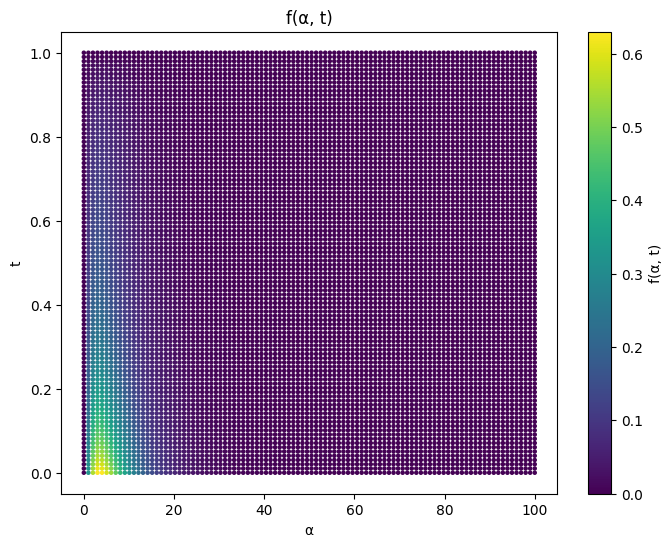

In [35]:
x1_coords = X_init[:, 0].numpy()
x2_coords = X_init[:, 1].numpy()
values = y_init.squeeze().numpy()
    
plt.figure(figsize=(8, 6))
plt.scatter(x1_coords, x2_coords, c=values, cmap='viridis', s=5)  # Use 'c' for color mapping
plt.colorbar(label='f(α, t)')
plt.xlabel('α')
plt.ylabel('t')
plt.title('f(α, t)')
plt.show()

In [36]:
from mpl_toolkits.mplot3d import Axes3D

x1_coords = X_init[:, 0]
x2_coords = X_init[:, 1]
values = y_init.squeeze().numpy()
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x1_coords, x2_coords, values, c=values, s=20)
plt.xlabel('α')
plt.ylabel('t')
ax.set_zlabel('f(α, t)')
ax.set_title('f(α, t)')

plt.show()

In [55]:
y_for_plot = y_init.view(100, 100).numpy()
y_for_plot.shape

(100, 100)

In [20]:
import plotly.graph_objects as go


t = X_init[:, 0].numpy()
alpha = X_init[:, 1].numpy()
f = y_init.squeeze().numpy()  # Remove the extra dimension

# Reshape data for surface plot
t_unique = np.unique(t)
alpha_unique = np.unique(alpha)
f_grid = f.reshape((len(alpha_unique), len(t_unique))) # Reshape to a 2D grid

fig = go.Figure(data=[go.Surface(
        x=t_unique,
        y=alpha_unique,
        z=f_grid
    )])

fig.update_layout(
    scene=dict(
        xaxis_title='t',
        yaxis_title='α',  # α unicode
        zaxis_title='f',
        xaxis=dict(range=[0, 100]),
        yaxis=dict(range=[0, 1])
    ),
    title='Function f(t, α)',  # Use unicode for alpha
    margin=dict(l=0, r=0, b=0, t=40)
)

fig.show()

In [15]:
X, y = scale_data(X_init, y_init, n_dim=2)
X.shape, y.shape

(torch.Size([10000, 2]), torch.Size([10000, 1]))

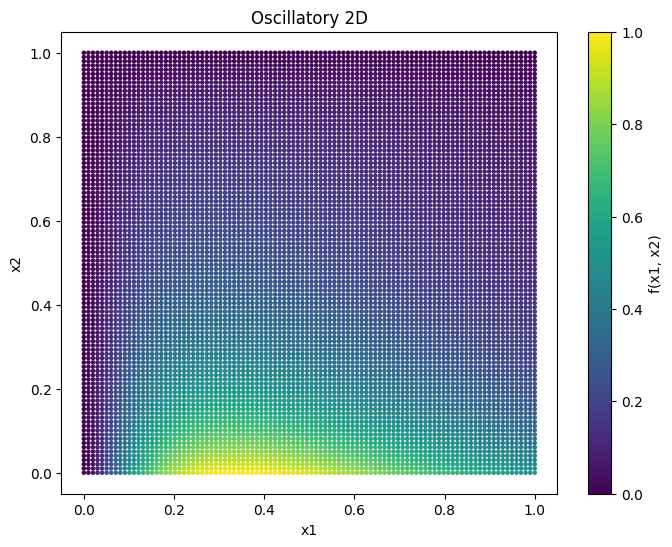

In [90]:
x1_coords = X[:, 0].numpy()
x2_coords = X[:, 1].numpy()
values = y.squeeze().numpy()
    
plt.figure(figsize=(8, 6))
plt.scatter(x1_coords, x2_coords, c=values, cmap='viridis', s=5)  # Use 'c' for color mapping
plt.colorbar(label='f(x1, x2)')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Oscillatory 2D')
plt.show()

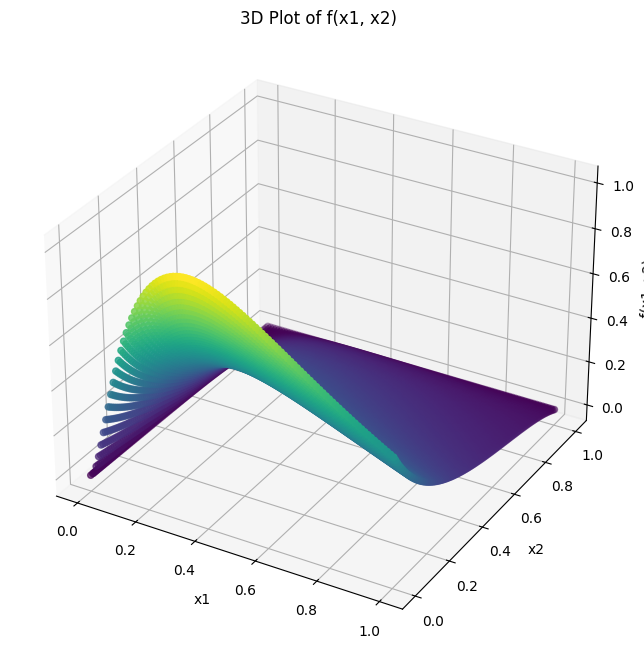

In [91]:
from mpl_toolkits.mplot3d import Axes3D

x1_coords = X[:, 0]
x2_coords = X[:, 1]
values = y.squeeze().numpy()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x1_coords, x2_coords, values, c=values, s=20)
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('f(x1, x2)')
ax.set_title('3D Plot of f(x1, x2)')

plt.show()

## Train-test datasets split

In [92]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1) # 10% from Lloyd's at all. "Using..."

In [93]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

(torch.Size([9000, 2]),
 torch.Size([1000, 2]),
 torch.Size([9000, 1]),
 torch.Size([1000, 1]))

## Model

### Hyperparams for the NN model

In [94]:
input_size = 2
hidden_size = 100
learning_rate = 0.001
num_epochs = 5000

### Model definition, compilation and training

In [95]:
model = MLP(input_size, hidden_size)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_history = train(model, criterion, optimizer, x_train, y_train, num_epochs)

Epoch [100/5000], Loss: 0.0195384454
Epoch [200/5000], Loss: 0.0134264836
Epoch [300/5000], Loss: 0.0128336884
Epoch [400/5000], Loss: 0.0128071262
Epoch [500/5000], Loss: 0.0127886366
Epoch [600/5000], Loss: 0.0127664870
Epoch [700/5000], Loss: 0.0127396919
Epoch [800/5000], Loss: 0.0127066579
Epoch [900/5000], Loss: 0.0126647511
Epoch [1000/5000], Loss: 0.0126096997
Epoch [1100/5000], Loss: 0.0125349350
Epoch [1200/5000], Loss: 0.0124311605
Epoch [1300/5000], Loss: 0.0122859543
Epoch [1400/5000], Loss: 0.0120824147
Epoch [1500/5000], Loss: 0.0117982402
Epoch [1600/5000], Loss: 0.0114103891
Epoch [1700/5000], Loss: 0.0109015387
Epoch [1800/5000], Loss: 0.0102625294
Epoch [1900/5000], Loss: 0.0095047569
Epoch [2000/5000], Loss: 0.0086742742
Epoch [2100/5000], Loss: 0.0078436434
Epoch [2200/5000], Loss: 0.0070830202
Epoch [2300/5000], Loss: 0.0064292154
Epoch [2400/5000], Loss: 0.0058774636
Epoch [2500/5000], Loss: 0.0053999848
Epoch [2600/5000], Loss: 0.0049695796
Epoch [2700/5000], Lo

In [96]:
summary(model, (input_size,)) # (input_size, ) - input shape

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 100]             300
           Sigmoid-2                  [-1, 100]               0
            Linear-3                    [-1, 1]             101
Total params: 401
Trainable params: 401
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


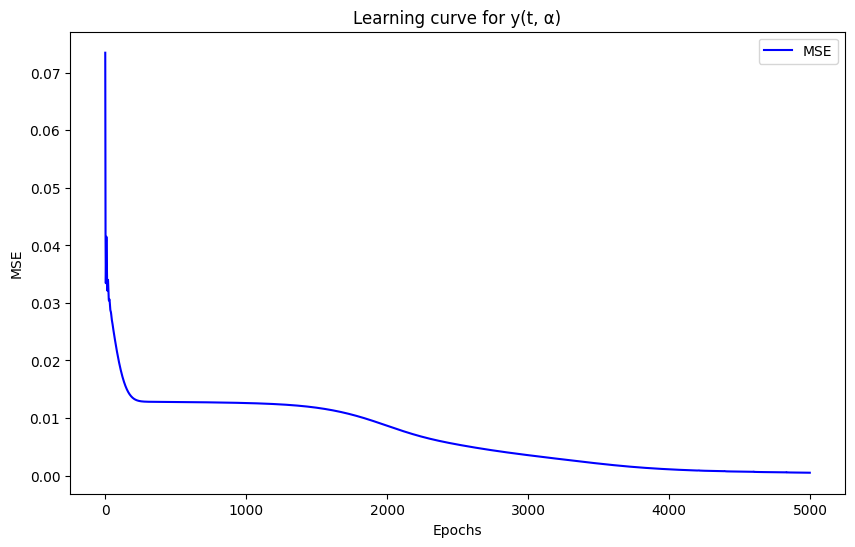

In [97]:
plt.figure(figsize=(10, 6))
plt.plot(train_history, label='MSE', color='b')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.title('Learning curve for y(t, α)')
plt.legend()
plt.grid(False)
plt.show()

### Model testing

In [98]:
test_loss = test(model, criterion, x_test, y_test)
print(f"Test Loss: {test_loss:.10f}")

Test Loss: 0.0005241741


## Model usage

In [99]:
nni_scaled = NeuralNumericalIntegration.integrate(model, aa_, bb_, n_dims=2)
nni_scaled

array([mpf('0.24346810073171105')], dtype=object)

In [100]:
nni = descale_result(float(nni_scaled[0]), X_init, y_init, frange=(0, 1), n_dim=2)
nni

tensor(1.5471)

# Debug

In [101]:
params = extract_params(model)

In [111]:
nni1 = NeuralNumericalIntegration.calculate(aa_, bb_, params, n_dims=2)
float(nni1[0].real)

0.1691073124182566

In [113]:
nni11 = descale_result(float(nni1[0].real), X_init, y_init, frange=(0, 1), n_dim=2)
nni11

tensor(1.0746)

In [114]:
nni2 = NeuralNumericalIntegration.calculate2(aa_, bb_, params, n_dims=2)
#float(nni2[0].real)
nni2

array([mpf('0.24346810073171105')], dtype=object)

In [116]:
nni22 = descale_result(float(nni2[0].real), X_init, y_init, frange=(0, 1), n_dim=2)
nni22

tensor(1.5471)